### CSA

C:\Users\dyari\AppData\Local\Temp\ipykernel_8504\1283774093.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Visualization saved as: adversarial_samples_comparison.jpg


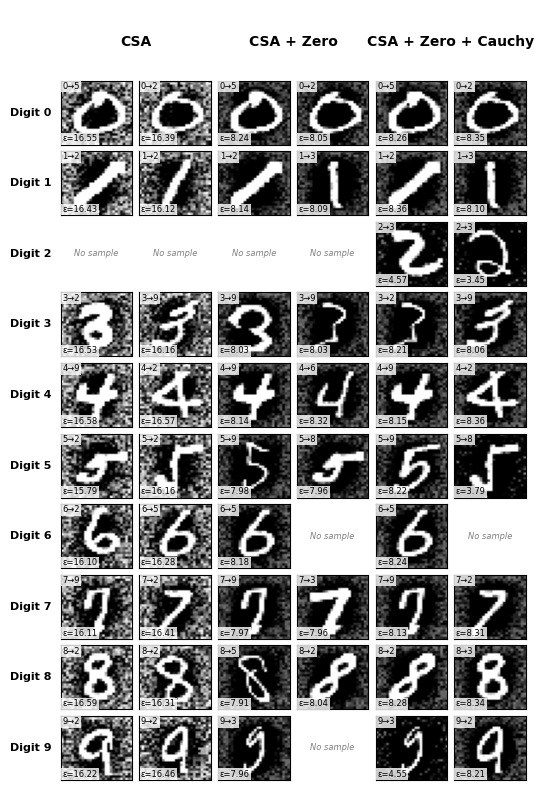

In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.gridspec as gridspec
from collections import defaultdict

def get_diverse_samples(files, samples_per_digit=1):
    """Helper function to get diverse samples with different target classes"""
    # Group by target class
    target_groups = defaultdict(list)
    for f in files:
        # Find the part that contains target class info after 'adv_orig'
        adv_part = f[f.find('adv_orig'):]
        # Extract target digit more reliably with error handling
        try:
            target = adv_part.split('_')[2][-1]
            target_groups[target].append(f)
        except (IndexError, KeyError) as e:
            print(f"Skipping file with unexpected format: {f}, error: {e}")
    
    # Try to get samples from different target classes
    selected = []
    target_classes = list(target_groups.keys())
    
    while len(selected) < samples_per_digit and target_groups:
        # Cycle through target classes
        for target in list(target_classes):  # Create a copy to avoid modification during iteration
            if target in target_groups and len(selected) < samples_per_digit:
                selected.append(target_groups[target].pop())
                # Remove target if no more samples
                if not target_groups[target]:
                    del target_groups[target]
                    target_classes.remove(target)
                    
        # Break if we can't find any more samples
        if not any(target_groups.values()):
            break
            
    return selected

def display_adversarial_samples(paths_and_titles, samples_per_digit=1, output_filename='adversarial_samples_comparison.jpg'):
    """
    Display adversarial samples from multiple directories with enhanced visualization.
    Each folder will have samples_per_digit columns, showing images of size 28x28.
    
    Parameters:
    -----------
    paths_and_titles : list of tuples
        List of (title, path) tuples for each method to display
    samples_per_digit : int
        Number of samples to show for each digit (0-9)
    output_filename : str
        Filename to save the visualization
    """
    # Number of columns per method
    num_columns = len(paths_and_titles) * samples_per_digit
    
    # Create figure with minimal spacing - SMALLER figure size for smaller images
    fig = plt.figure(figsize=(num_columns * 1.0, 10))  # Reduced multiplier from 1.5 to 1.0
    gs = gridspec.GridSpec(11, num_columns, figure=fig)
    gs.update(wspace=0.1, hspace=0.1)
    
    # Iterate over the paths and titles
    for method_idx, (title, path) in enumerate(paths_and_titles):
        # Dictionary to store filenames for each original digit
        digit_files = {i: [] for i in range(10)}
        
        # Check if directory exists
        if not os.path.exists(path):
            print(f"Warning: Path does not exist: {path}")
            continue
            
        # Collect files for each original digit
        try:
            for filename in os.listdir(path):
                if 'adv_orig' in filename:
                    # Extract the relevant part starting from 'adv_orig'
                    adv_part = filename[filename.find('adv_orig'):]
                    # Extract original digit
                    try:
                        orig_digit = int(adv_part.split('_')[1][-1])
                        digit_files[orig_digit].append(os.path.join(path, filename))
                    except (ValueError, IndexError) as e:
                        print(f"Skipping file with unexpected format: {filename}, error: {e}")
        except FileNotFoundError:
            print(f"Error: Directory not found: {path}")
            continue
        
        # Calculate column span for this method
        col_start = method_idx * samples_per_digit
        col_end = col_start + samples_per_digit
        
        # Add title for the method spanning all its columns (first row)
        ax_title = fig.add_subplot(gs[0, col_start:col_end])
        ax_title.axis('off')
        ax_title.text(0.5, 0.5, title, fontsize=10, ha='center', va='center', fontweight='bold')
        
        # For each digit (0-9), add the adversarial samples
        for digit in range(10):
            # Get diverse samples for this digit
            samples = get_diverse_samples(digit_files[digit], samples_per_digit)
            
            # Display each sample
            for idx, sample_path in enumerate(samples):
                if idx < samples_per_digit:
                    ax = fig.add_subplot(gs[digit + 1, col_start + idx])
                    
                    try:
                        img = Image.open(sample_path)
                        ax.imshow(np.array(img), cmap='gray', aspect='auto')
                        
                        # Extract target class and magnitude from the filename
                        filename = os.path.basename(sample_path)
                        adv_part = filename[filename.find('adv_orig'):]
                        target_class = adv_part.split('_')[2][-1]
                        
                        # Handle different magnitude formats (mag or eps)
                        try:
                            if 'mag' in adv_part:
                                magnitude = float(adv_part.split('_')[3][3:])
                            elif 'eps' in adv_part:
                                magnitude = float(adv_part.split('_')[3][3:])
                            else:
                                magnitude = float(adv_part.split('_')[3])
                        except (ValueError, IndexError):
                            magnitude = float('nan')
                        
                        # Display original digit and target class with magnitude
                        # Smaller text for smaller images
                        ax.text(0.02, 0.98, f'{digit}→{target_class}',
                               transform=ax.transAxes,
                               fontsize=6, ha='left', va='top',  # Reduced from 8 to 6
                               bbox=dict(facecolor='white', alpha=0.8,
                                         edgecolor='none', pad=1))
                        
                        ax.text(0.02, 0.02, f'ε={magnitude:.2f}',
                               transform=ax.transAxes,
                               fontsize=6, ha='left', va='bottom',  # Reduced from 8 to 6
                               bbox=dict(facecolor='white', alpha=0.8,
                                         edgecolor='none', pad=1))
                        
                    except Exception as e:
                        print(f"Error loading image {sample_path}: {str(e)}")
                        ax.text(0.5, 0.5, 'Error', ha='center', va='center')
                    
                    # Remove axes
                    ax.set_xticks([])
                    ax.set_yticks([])
            
            # Fill empty slots if there are fewer samples than required
            for idx in range(len(samples), samples_per_digit):
                ax = fig.add_subplot(gs[digit + 1, col_start + idx])
                ax.axis('off')
                ax.text(0.5, 0.5, 'No sample', fontsize=6, ha='center', va='center',  # Reduced from 8 to 6
                       style='italic', color='gray')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    # Add a row for digit labels on the left
    for digit in range(10):
        # Create a "row header" for each digit
        ax_row = fig.add_subplot(gs[digit + 1, :])
        ax_row.axis('off')
        ax_row.text(-0.02, 0.5, f"Digit {digit}", fontsize=8, ha='right', va='center',  # Reduced from 10 to 8
                   transform=ax_row.transAxes, fontweight='bold')
        ax_row.set_zorder(-1)  # Put behind the image plots
    
    # Save figure with high resolution
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"Visualization saved as: {output_filename}")
    plt.show()

# Example usage with relative paths for easier portability
paths_and_titles = [
    ("CSA", "./CSA_images/Adversarial"),
    ("CSA + Zero", "./CSAzero_images/Adversarial"),
    ("CSA + Zero + Cauchy", "./CSAzeroCau_images/Adversarial")
]

# You can adjust the samples per digit as needed
display_adversarial_samples(paths_and_titles, samples_per_digit=2, 
                           output_filename='adversarial_samples_comparison.jpg')

### Seen and unseen data - Experiment

C:\Users\dyari\AppData\Local\Temp\ipykernel_8504\2434482321.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Visualization saved as: adversarial_samples_comparison.jpg


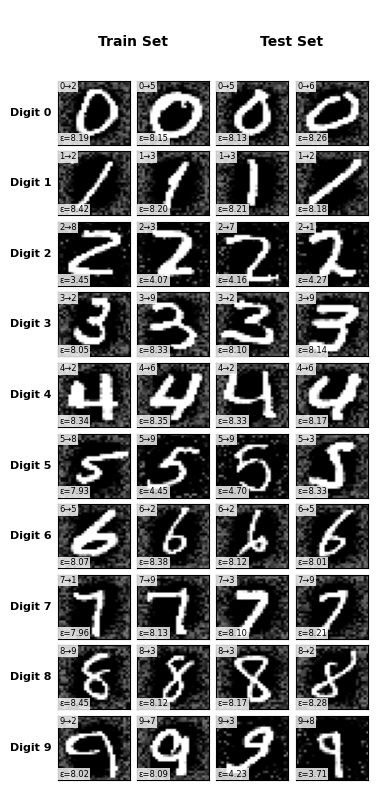

In [22]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.gridspec as gridspec
from collections import defaultdict

def get_diverse_samples(files, samples_per_digit=1):
    """Helper function to get diverse samples with different target classes"""
    # Group by target class
    target_groups = defaultdict(list)
    for f in files:
        # Find the part that contains target class info after 'adv_orig'
        adv_part = f[f.find('adv_orig'):]
        # Extract target digit more reliably with error handling
        try:
            target = adv_part.split('_')[2][-1]
            target_groups[target].append(f)
        except (IndexError, KeyError) as e:
            print(f"Skipping file with unexpected format: {f}, error: {e}")
    
    # Try to get samples from different target classes
    selected = []
    target_classes = list(target_groups.keys())
    
    while len(selected) < samples_per_digit and target_groups:
        # Cycle through target classes
        for target in list(target_classes):  # Create a copy to avoid modification during iteration
            if target in target_groups and len(selected) < samples_per_digit:
                selected.append(target_groups[target].pop())
                # Remove target if no more samples
                if not target_groups[target]:
                    del target_groups[target]
                    target_classes.remove(target)
                    
        # Break if we can't find any more samples
        if not any(target_groups.values()):
            break
            
    return selected

def display_adversarial_samples(paths_and_titles, samples_per_digit=1, output_filename='adversarial_samples_comparison.jpg'):
    """
    Display adversarial samples from multiple directories with enhanced visualization.
    Each folder will have samples_per_digit columns, showing images of size 28x28.
    
    Parameters:
    -----------
    paths_and_titles : list of tuples
        List of (title, path) tuples for each method to display
    samples_per_digit : int
        Number of samples to show for each digit (0-9)
    output_filename : str
        Filename to save the visualization
    """
    # Number of columns per method
    num_columns = len(paths_and_titles) * samples_per_digit
    
    # Create figure with minimal spacing - SMALLER figure size for smaller images
    fig = plt.figure(figsize=(num_columns * 1.0, 10))  # Reduced multiplier from 1.5 to 1.0
    gs = gridspec.GridSpec(11, num_columns, figure=fig)
    gs.update(wspace=0.1, hspace=0.1)
    
    # Iterate over the paths and titles
    for method_idx, (title, path) in enumerate(paths_and_titles):
        # Dictionary to store filenames for each original digit
        digit_files = {i: [] for i in range(10)}
        
        # Check if directory exists
        if not os.path.exists(path):
            print(f"Warning: Path does not exist: {path}")
            continue
            
        # Collect files for each original digit
        try:
            for filename in os.listdir(path):
                if 'adv_orig' in filename:
                    # Extract the relevant part starting from 'adv_orig'
                    adv_part = filename[filename.find('adv_orig'):]
                    # Extract original digit
                    try:
                        orig_digit = int(adv_part.split('_')[1][-1])
                        digit_files[orig_digit].append(os.path.join(path, filename))
                    except (ValueError, IndexError) as e:
                        print(f"Skipping file with unexpected format: {filename}, error: {e}")
        except FileNotFoundError:
            print(f"Error: Directory not found: {path}")
            continue
        
        # Calculate column span for this method
        col_start = method_idx * samples_per_digit
        col_end = col_start + samples_per_digit
        
        # Add title for the method spanning all its columns (first row)
        ax_title = fig.add_subplot(gs[0, col_start:col_end])
        ax_title.axis('off')
        ax_title.text(0.5, 0.5, title, fontsize=10, ha='center', va='center', fontweight='bold')
        
        # For each digit (0-9), add the adversarial samples
        for digit in range(10):
            # Get diverse samples for this digit
            samples = get_diverse_samples(digit_files[digit], samples_per_digit)
            
            # Display each sample
            for idx, sample_path in enumerate(samples):
                if idx < samples_per_digit:
                    ax = fig.add_subplot(gs[digit + 1, col_start + idx])
                    
                    try:
                        img = Image.open(sample_path)
                        ax.imshow(np.array(img), cmap='gray', aspect='auto')
                        
                        # Extract target class and magnitude from the filename
                        filename = os.path.basename(sample_path)
                        adv_part = filename[filename.find('adv_orig'):]
                        target_class = adv_part.split('_')[2][-1]
                        
                        # Handle different magnitude formats (mag or eps)
                        try:
                            if 'mag' in adv_part:
                                magnitude = float(adv_part.split('_')[3][3:])
                            elif 'eps' in adv_part:
                                magnitude = float(adv_part.split('_')[3][3:])
                            else:
                                magnitude = float(adv_part.split('_')[3])
                        except (ValueError, IndexError):
                            magnitude = float('nan')
                        
                        # Display original digit and target class with magnitude
                        # Smaller text for smaller images
                        ax.text(0.02, 0.98, f'{digit}→{target_class}',
                               transform=ax.transAxes,
                               fontsize=6, ha='left', va='top',  # Reduced from 8 to 6
                               bbox=dict(facecolor='white', alpha=0.8,
                                         edgecolor='none', pad=1))
                        
                        ax.text(0.02, 0.02, f'ε={magnitude:.2f}',
                               transform=ax.transAxes,
                               fontsize=6, ha='left', va='bottom',  # Reduced from 8 to 6
                               bbox=dict(facecolor='white', alpha=0.8,
                                         edgecolor='none', pad=1))
                        
                    except Exception as e:
                        print(f"Error loading image {sample_path}: {str(e)}")
                        ax.text(0.5, 0.5, 'Error', ha='center', va='center')
                    
                    # Remove axes
                    ax.set_xticks([])
                    ax.set_yticks([])
            
            # Fill empty slots if there are fewer samples than required
            for idx in range(len(samples), samples_per_digit):
                ax = fig.add_subplot(gs[digit + 1, col_start + idx])
                ax.axis('off')
                ax.text(0.5, 0.5, 'No sample', fontsize=6, ha='center', va='center',  # Reduced from 8 to 6
                       style='italic', color='gray')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    # Add a row for digit labels on the left
    for digit in range(10):
        # Create a "row header" for each digit
        ax_row = fig.add_subplot(gs[digit + 1, :])
        ax_row.axis('off')
        ax_row.text(-0.02, 0.5, f"Digit {digit}", fontsize=8, ha='right', va='center',  # Reduced from 10 to 8
                   transform=ax_row.transAxes, fontweight='bold')
        ax_row.set_zorder(-1)  # Put behind the image plots
    
    # Save figure with high resolution
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"Visualization saved as: {output_filename}")
    plt.show()

# Updated to use just two folders
paths_and_titles = [
    ("Train Set", "./Seen_adversarial_images/Adversarial"),
    ("Test Set", "./Unseen_adversarial_images/Adversarial")
]

# You can adjust the samples per digit as needed
display_adversarial_samples(paths_and_titles, samples_per_digit=2, 
                           output_filename='adversarial_samples_comparison.jpg')

### Different Configurations

C:\Users\dyari\AppData\Local\Temp\ipykernel_8504\3837263993.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Visualization saved as: adversarial_samples_comparison.jpg


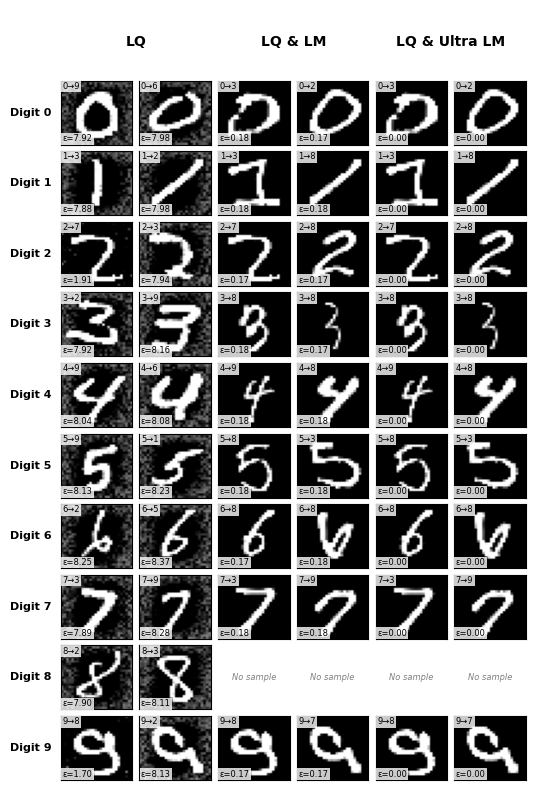

In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.gridspec as gridspec
from collections import defaultdict

def get_diverse_samples(files, samples_per_digit=1):
    """Helper function to get diverse samples with different target classes"""
    # Group by target class
    target_groups = defaultdict(list)
    for f in files:
        # Find the part that contains target class info after 'adv_orig'
        adv_part = f[f.find('adv_orig'):]
        # Extract target digit more reliably with error handling
        try:
            target = adv_part.split('_')[2][-1]
            target_groups[target].append(f)
        except (IndexError, KeyError) as e:
            print(f"Skipping file with unexpected format: {f}, error: {e}")
    
    # Try to get samples from different target classes
    selected = []
    target_classes = list(target_groups.keys())
    
    while len(selected) < samples_per_digit and target_groups:
        # Cycle through target classes
        for target in list(target_classes):  # Create a copy to avoid modification during iteration
            if target in target_groups and len(selected) < samples_per_digit:
                selected.append(target_groups[target].pop())
                # Remove target if no more samples
                if not target_groups[target]:
                    del target_groups[target]
                    target_classes.remove(target)
                    
        # Break if we can't find any more samples
        if not any(target_groups.values()):
            break
            
    return selected

def display_adversarial_samples(paths_and_titles, samples_per_digit=1, output_filename='adversarial_samples_comparison.jpg'):
    """
    Display adversarial samples from multiple directories with enhanced visualization.
    Each folder will have samples_per_digit columns, showing images of size 28x28.
    
    Parameters:
    -----------
    paths_and_titles : list of tuples
        List of (title, path) tuples for each method to display
    samples_per_digit : int
        Number of samples to show for each digit (0-9)
    output_filename : str
        Filename to save the visualization
    """
    # Number of columns per method
    num_columns = len(paths_and_titles) * samples_per_digit
    
    # Create figure with minimal spacing - SMALLER figure size for smaller images
    fig = plt.figure(figsize=(num_columns * 1.0, 10))  # Reduced multiplier from 1.5 to 1.0
    gs = gridspec.GridSpec(11, num_columns, figure=fig)
    gs.update(wspace=0.1, hspace=0.1)
    
    # Iterate over the paths and titles
    for method_idx, (title, path) in enumerate(paths_and_titles):
        # Dictionary to store filenames for each original digit
        digit_files = {i: [] for i in range(10)}
        
        # Check if directory exists
        if not os.path.exists(path):
            print(f"Warning: Path does not exist: {path}")
            continue
            
        # Collect files for each original digit
        try:
            for filename in os.listdir(path):
                if 'adv_orig' in filename:
                    # Extract the relevant part starting from 'adv_orig'
                    adv_part = filename[filename.find('adv_orig'):]
                    # Extract original digit
                    try:
                        orig_digit = int(adv_part.split('_')[1][-1])
                        digit_files[orig_digit].append(os.path.join(path, filename))
                    except (ValueError, IndexError) as e:
                        print(f"Skipping file with unexpected format: {filename}, error: {e}")
        except FileNotFoundError:
            print(f"Error: Directory not found: {path}")
            continue
        
        # Calculate column span for this method
        col_start = method_idx * samples_per_digit
        col_end = col_start + samples_per_digit
        
        # Add title for the method spanning all its columns (first row)
        ax_title = fig.add_subplot(gs[0, col_start:col_end])
        ax_title.axis('off')
        ax_title.text(0.5, 0.5, title, fontsize=10, ha='center', va='center', fontweight='bold')
        
        # For each digit (0-9), add the adversarial samples
        for digit in range(10):
            # Get diverse samples for this digit
            samples = get_diverse_samples(digit_files[digit], samples_per_digit)
            
            # Display each sample
            for idx, sample_path in enumerate(samples):
                if idx < samples_per_digit:
                    ax = fig.add_subplot(gs[digit + 1, col_start + idx])
                    
                    try:
                        img = Image.open(sample_path)
                        ax.imshow(np.array(img), cmap='gray', aspect='auto')
                        
                        # Extract target class and magnitude from the filename
                        filename = os.path.basename(sample_path)
                        adv_part = filename[filename.find('adv_orig'):]
                        target_class = adv_part.split('_')[2][-1]
                        
                        # Handle different magnitude formats (mag or eps)
                        try:
                            if 'mag' in adv_part:
                                magnitude = float(adv_part.split('_')[3][3:])
                            elif 'eps' in adv_part:
                                magnitude = float(adv_part.split('_')[3][3:])
                            else:
                                magnitude = float(adv_part.split('_')[3])
                        except (ValueError, IndexError):
                            magnitude = float('nan')
                        
                        # Display original digit and target class with magnitude
                        # Smaller text for smaller images
                        ax.text(0.02, 0.98, f'{digit}→{target_class}',
                               transform=ax.transAxes,
                               fontsize=6, ha='left', va='top',  # Reduced from 8 to 6
                               bbox=dict(facecolor='white', alpha=0.8,
                                         edgecolor='none', pad=1))
                        
                        ax.text(0.02, 0.02, f'ε={magnitude:.2f}',
                               transform=ax.transAxes,
                               fontsize=6, ha='left', va='bottom',  # Reduced from 8 to 6
                               bbox=dict(facecolor='white', alpha=0.8,
                                         edgecolor='none', pad=1))
                        
                    except Exception as e:
                        print(f"Error loading image {sample_path}: {str(e)}")
                        ax.text(0.5, 0.5, 'Error', ha='center', va='center')
                    
                    # Remove axes
                    ax.set_xticks([])
                    ax.set_yticks([])
            
            # Fill empty slots if there are fewer samples than required
            for idx in range(len(samples), samples_per_digit):
                ax = fig.add_subplot(gs[digit + 1, col_start + idx])
                ax.axis('off')
                ax.text(0.5, 0.5, 'No sample', fontsize=6, ha='center', va='center',  # Reduced from 8 to 6
                       style='italic', color='gray')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    # Add a row for digit labels on the left
    for digit in range(10):
        # Create a "row header" for each digit
        ax_row = fig.add_subplot(gs[digit + 1, :])
        ax_row.axis('off')
        ax_row.text(-0.02, 0.5, f"Digit {digit}", fontsize=8, ha='right', va='center',  # Reduced from 10 to 8
                   transform=ax_row.transAxes, fontweight='bold')
        ax_row.set_zorder(-1)  # Put behind the image plots
    
    # Save figure with high resolution
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"Visualization saved as: {output_filename}")
    plt.show()

# Example usage with relative paths for easier portability
paths_and_titles = [
    ("LQ", "./LowQuery_Unseen_adversarial_images/Adversarial"),
    ("LQ & LM", "./LowMag_LowQuery_Unseen_adversarial_images/Adversarial"),
    ("LQ & Ultra LM", "./ExLowMag_LowQuery_Unseen_adversarial_images/Adversarial")
]

# You can adjust the samples per digit as needed
display_adversarial_samples(paths_and_titles, samples_per_digit=2, 
                           output_filename='adversarial_samples_comparison.jpg')

Visualization saved as: adversarial_samples.jpg


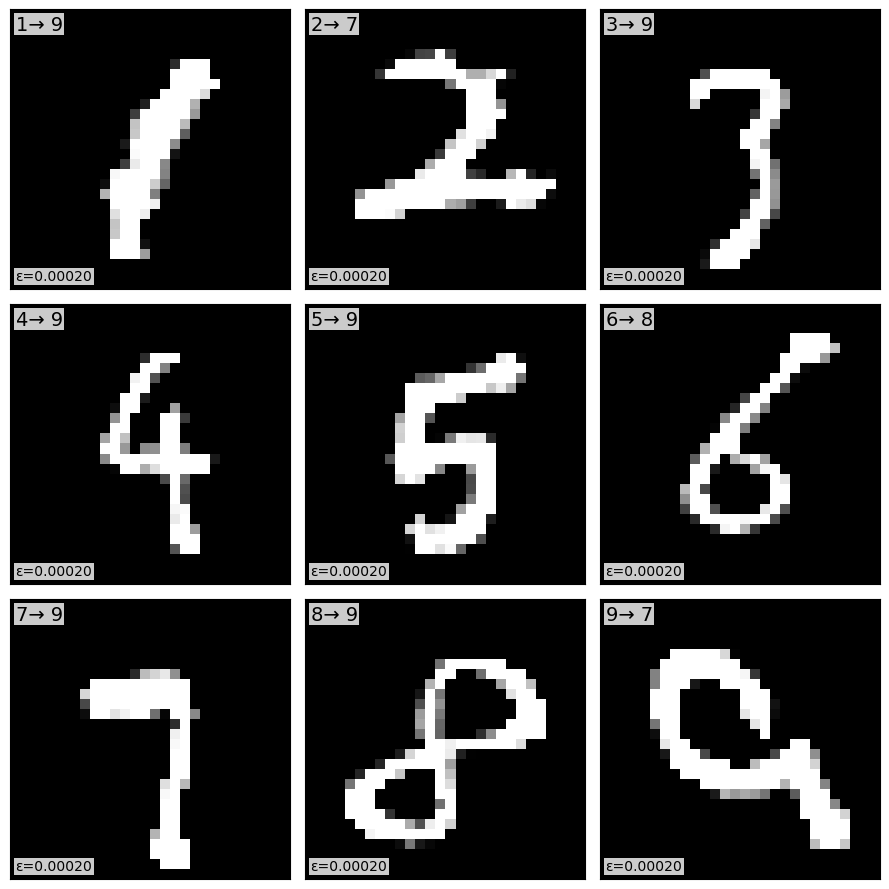

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

def display_adversarial_samples(folder_path, output_filename='adversarial_samples.jpg'):
    """
    Display adversarial samples from a single directory in a 3x3 grid.
    Shows one randomly selected image per digit (1-9).
    
    Parameters:
    -----------
    folder_path : str
        Path to the folder containing adversarial images
    output_filename : str
        Filename to save the visualization
    """
    # Number of rows and columns for the grid
    nrows, ncols = 3, 3
    
    # Create figure for a 3x3 grid
    fig, axes = plt.subplots(nrows, ncols, figsize=(9, 9))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Dictionary to store filenames for each original digit
    digit_files = {i: [] for i in range(1, 10)}  # Using digits 1-9
    
    # Check if directory exists
    if not os.path.exists(folder_path):
        print(f"Warning: Path does not exist: {folder_path}")
        return
        
    # Collect files for each original digit
    try:
        for filename in os.listdir(folder_path):
            if 'adv_orig' in filename:
                # Extract the relevant part starting from 'adv_orig'
                adv_part = filename[filename.find('adv_orig'):]
                # Extract original digit
                try:
                    orig_digit = int(adv_part.split('_')[1][-1])
                    if 1 <= orig_digit <= 9:  # Only include digits 1-9
                        digit_files[orig_digit].append(os.path.join(folder_path, filename))
                except (ValueError, IndexError) as e:
                    print(f"Skipping file with unexpected format: {filename}, error: {e}")
    except FileNotFoundError:
        print(f"Error: Directory not found: {folder_path}")
        return
    
    # Flatten the axes array for easier iteration
    axes_flat = axes.flatten()
    
    # For each digit (1-9), add one randomly selected adversarial sample
    for i, digit in enumerate(range(1, 10)):
        # Get the corresponding axis
        ax = axes_flat[i]
        
        # Get all samples for this digit
        samples = digit_files[digit]
        
        if samples:  # If there's at least one sample for this digit
            # Randomly select one sample
            sample_path = random.choice(samples)
            
            try:
                img = Image.open(sample_path)
                ax.imshow(np.array(img), cmap='gray', aspect='auto')
                
                # Extract target class and magnitude from the filename
                filename = os.path.basename(sample_path)
                adv_part = filename[filename.find('adv_orig'):]
                target_class = adv_part.split('_')[2][-1]
                
                # Handle different magnitude formats (mag or eps)
                try:
                    if 'mag' in adv_part:
                        magnitude = float(adv_part.split('_')[3][3:])
                    elif 'eps' in adv_part:
                        magnitude = float(adv_part.split('_')[3][3:])
                    else:
                        magnitude = float(adv_part.split('_')[3])
                except (ValueError, IndexError):
                    magnitude = float('nan')
                
                # Display original digit and target class with magnitude
                ax.text(0.02, 0.98, f'{digit}→ {target_class}',
                       transform=ax.transAxes,
                       fontsize=14, ha='left', va='top',
                       bbox=dict(facecolor='white', alpha=0.8,
                                 edgecolor='none', pad=1))
                
                ax.text(0.02, 0.02, f'ε={magnitude:.5f}',
                       transform=ax.transAxes,
                       fontsize=10, ha='left', va='bottom',
                       bbox=dict(facecolor='white', alpha=0.8,
                                 edgecolor='none', pad=1))
                
            except Exception as e:
                print(f"Error loading image {sample_path}: {str(e)}")
                ax.text(0.5, 0.5, 'Error', ha='center', va='center')
        else:
            # If no sample is available for this digit
            ax.text(0.5, 0.5, f'No sample for digit {digit}', 
                   fontsize=8, ha='center', va='center',
                   style='italic', color='gray')
        
        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    
    # Save figure with high resolution
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"Visualization saved as: {output_filename}")
    plt.show()

# Use the single folder specified
folder_path = r"C:\Users\dyari\OneDrive\Desktop\PhD_2nd_Paper\CNN_ExLowMag_LowQuery_Unseen_adversarial_images\Adversarial"

# Run the function
display_adversarial_samples(folder_path, output_filename='adversarial_samples.jpg')